# Imports and constants

In [335]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.model_selection import cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, LabelEncoder, OneHotEncoder
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

PROJECT_NAME = "sweethome3d"
RANDOM_SEED = 50
K = 10
PRIMARY_COLOR = "#C71918"
FEATURE_NAMES = ["Controller", "Coordinator", "Information Holder", "Interfacer", "Service Provider", "Structurer"]
FEATURE_ABBREV = ["CT", "CO", "IH", "IT", "SP", "ST"]
ROUND = 2

mpl.rcParams["figure.figsize"] = (6, 4)
pd.set_option("display.max_colwidth", None)

# Exploratory code

#### Data processing

In [319]:
# Load the data.
data_path = f"/Users/mboopi/Documents/GitHub/JavaClassClassification/data/dataset/{PROJECT_NAME}/features_{PROJECT_NAME}_FINAL.csv"
data_path2 = "/Users/mboopi/Documents/KY/CSE_Y3/Q2:3/Thesis/JSS2019_SCAM_ReplicationPackage/Classification Experiment/dataset/multi-class classification/three-cases-20190301.csv"
raw_data = pd.read_csv(data_path)
raw_data2 = pd.read_csv(data_path2)

# Drop the class names and split data into features and labels.
X = raw_data.drop(columns=["className", "label"])
# X = X[["ratioInternalExternal", "ratioIncomingOutgoing", "numUniqueIncomingCalls", "numUniqueOutgoingCalls", "avgExecTime", "avgDepth", "avgObjectSize"]]
y = raw_data["label"]
X_2 = raw_data2.drop(columns=["index", "fullpathname", "classname", "label"])
y_2 = raw_data2["label"]

#### Data exploration and validation
The dataset based on dynamic features cover 501 out of the 546 classes, used by the paper.
For each RS, we miss the following number of classes:
- IH: 11
- SP: 30
- IT: 3
- CT: 0
- ST: 1
- CO: 0

Information Holder    216
Service Provider      129
Interfacer             60
Controller             38
Structurer             37
Coordinator            21
Name: label, dtype: int64


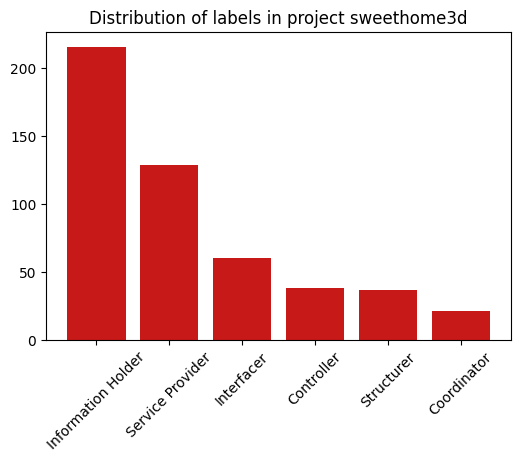

Average correlation of each feature, to any other feature:
numIntCalls               0.392624
numExtCalls               0.389219
ratioInternalExternal     0.073177
numIncomingCalls          0.294424
numOutgoingCalls          0.395818
ratioIncomingOutgoing     0.099023
numUniqueIncomingCalls    0.247150
numUniqueOutgoingCalls    0.234090
numObjectsCreated         0.329139
percObjectCreation        0.012274
numLeaves                 0.290984
percLeaves                0.028990
avgExecTime               0.015514
avgDepth                 -0.000820
numObjectsTotal           0.149297
numObjectsDeallocated     0.161112
percDeallocated           0.040644
avgObjectSize             0.005285
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


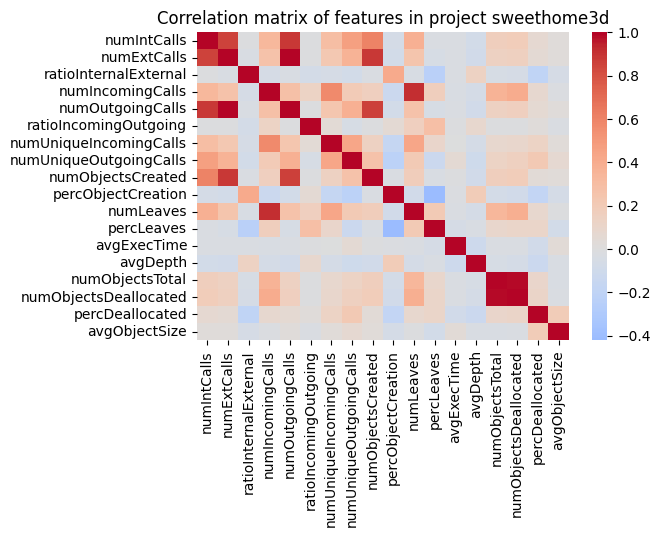

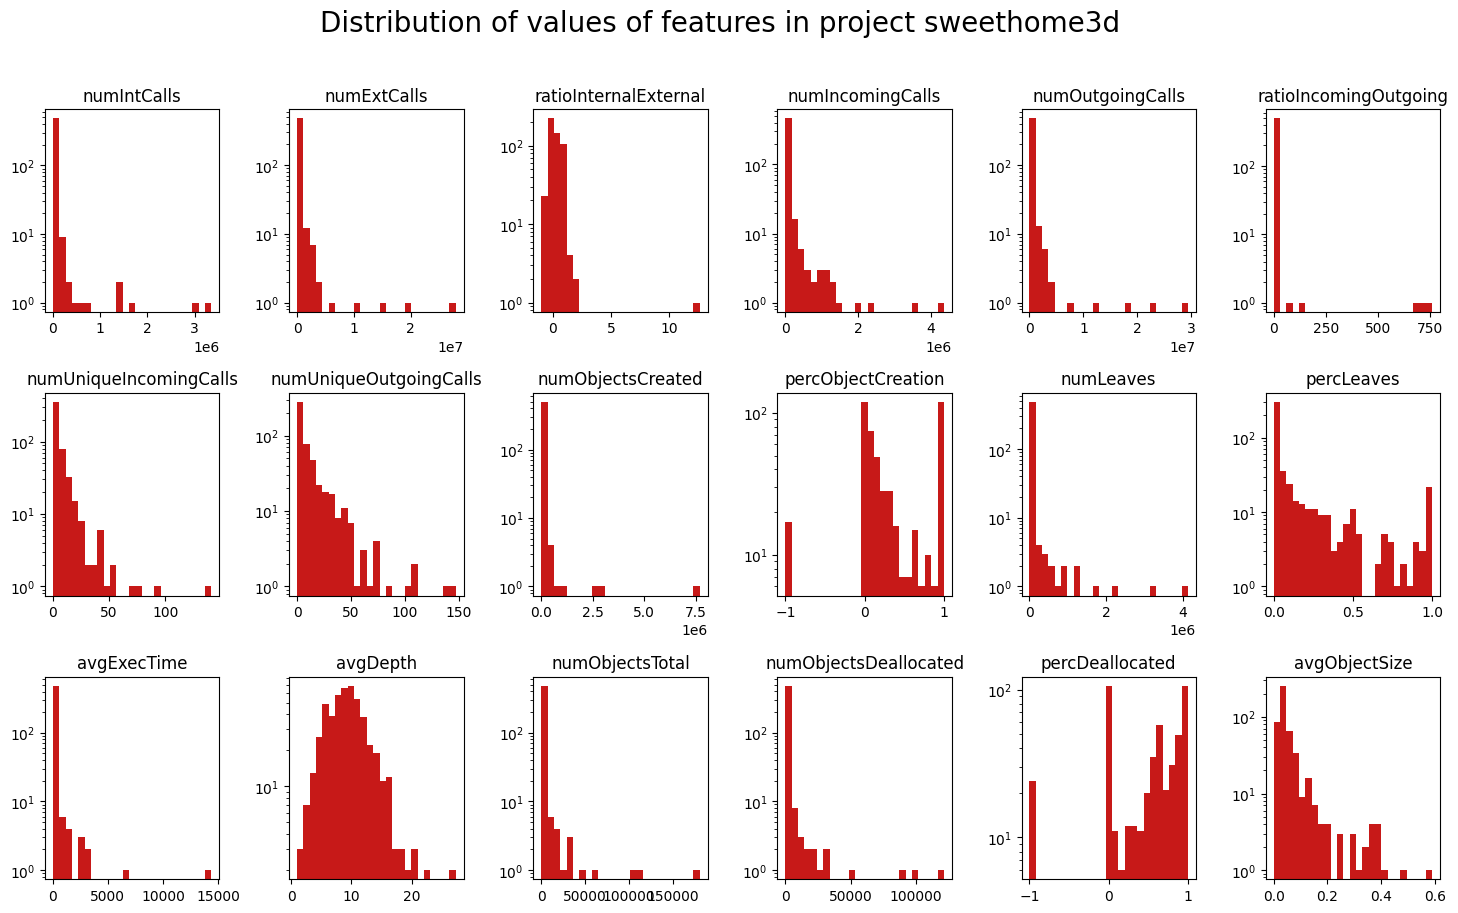

numIntCalls: MIN - MAX - MEAN - STD - MEDIAN
0 - 3354928 - 33501.944 - 241103.549 - 46.0


numExtCalls: MIN - MAX - MEAN - STD - MEDIAN
0 - 27907625 - 288782.046 - 1797144.754 - 430.0


ratioInternalExternal: MIN - MAX - MEAN - STD - MEDIAN
-1.0 - 12.641 - 0.277 - 0.732 - 0.099


numIncomingCalls: MIN - MAX - MEAN - STD - MEDIAN
0 - 4351754 - 70688.882 - 334302.107 - 187.0


numOutgoingCalls: MIN - MAX - MEAN - STD - MEDIAN
0 - 29346541 - 322283.99 - 2006342.453 - 600.0


ratioIncomingOutgoing: MIN - MAX - MEAN - STD - MEDIAN
-1.0 - 759.038 - 5.348 - 56.224 - 0.286


numUniqueIncomingCalls: MIN - MAX - MEAN - STD - MEDIAN
0 - 141 - 6.77 - 11.334 - 3.0


numUniqueOutgoingCalls: MIN - MAX - MEAN - STD - MEDIAN
0 - 147 - 11.828 - 17.891 - 5.0


numObjectsCreated: MIN - MAX - MEAN - STD - MEDIAN
0 - 7704333 - 38471.461 - 391866.028 - 134.0


percObjectCreation: MIN - MAX - MEAN - STD - MEDIAN
-1.0 - 1.0 - 0.344 - 0.466 - 0.182


numLeaves: MIN - MAX - MEAN - STD - MEDIAN
0 - 4139306 - 4276

In [320]:
# Check distribution of the labels in the dataset.
frequencies = y.value_counts()
print(frequencies)

plt.bar(frequencies.index, frequencies.values, color=PRIMARY_COLOR)
plt.title(f"Distribution of labels in project {PROJECT_NAME}")
plt.xticks(rotation=45)
plt.show()


# Check feature correlation by computing a correlation matrix that shows the Pearson correlation coefficient (r) between each pair of features. 
# This r is a measure of the linear relationship between 2 variables. It ranges from -1 (perfect negative correlation) to 1 (perfect positive correlation), 
# with 0 indicating no correlation.
corr_matrix = X.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Compute the average value of r by converting df to np array.
                                                      # Compute the average only on the upper triangle of the matrix, excluding diagonals.
avg_r = np.mean(corr_matrix[mask]) 
print("Average correlation of each feature, to any other feature:")
print(avg_r)

sns.heatmap(corr_matrix, cmap="coolwarm", center=0);
plt.title(f"Correlation matrix of features in project {PROJECT_NAME}")


# Plot distribution of each feature.
columns = X.columns.tolist()
num_features = X.shape[1]

fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(18, 10))
fig.suptitle(f"Distribution of values of features in project {PROJECT_NAME}", fontsize=20)
axs = axs.flatten()
for i in range(num_features):
    col_name = columns[i]
    axs[i].hist(X[col_name], bins=25, color=PRIMARY_COLOR, log=True)
    axs[i].set_title(col_name)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()  


# Some extra sanity checks to validate the values of our features.
rounding = 3
for feature in columns:
    min_val = X[feature].min().round(rounding)
    max_val = X[feature].max().round(rounding)
    avg_val = X[feature].mean().round(rounding)
    std_val = X[feature].std().round(rounding)
    med_val = X[feature].median().round(rounding)
    print(f"{feature}: MIN - MAX - MEAN - STD - MEDIAN")
    print(f"{min_val} - {max_val} - {avg_val} - {std_val} - {med_val}")
    print("\n")
    

#### Training

===AVG, VAR===
Precision:  0.700403293796384 0.04645646692591911
Recall:  0.6985882352941176 0.03288566751683293
F1:  0.662051253346717 0.0334185019613898
MCC:  0.5732142734085004 0.04959899685922128


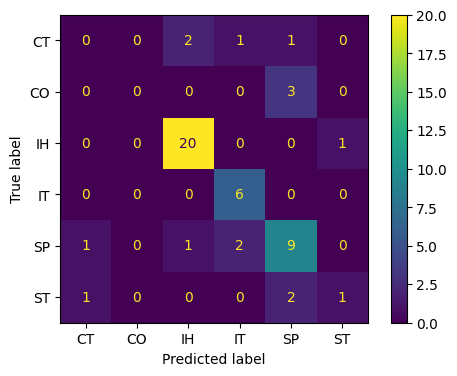

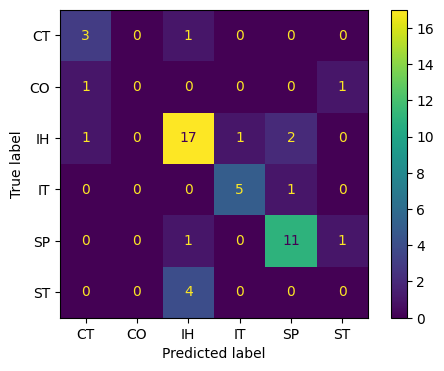

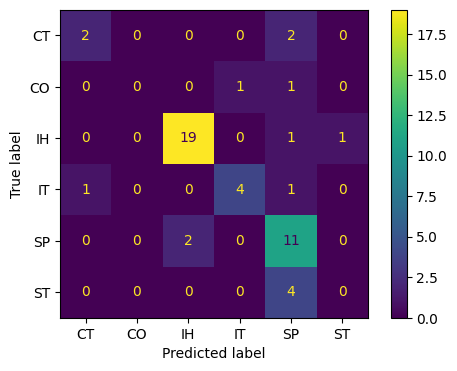

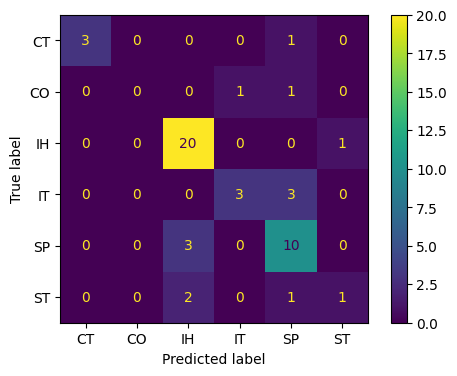

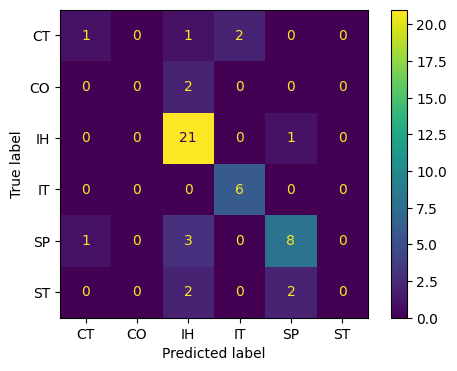

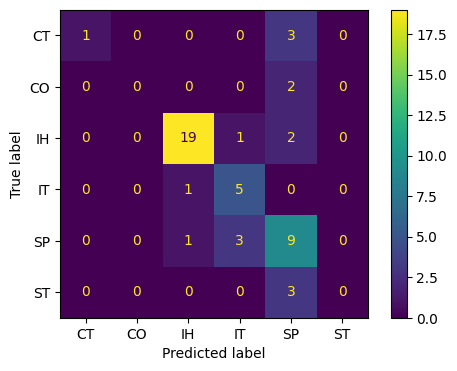

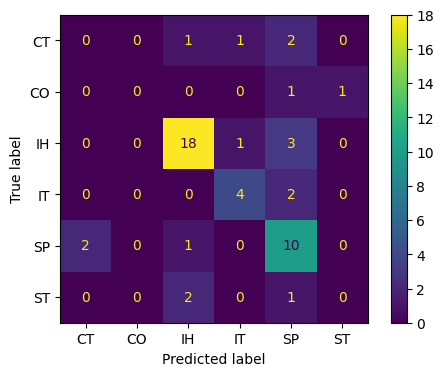

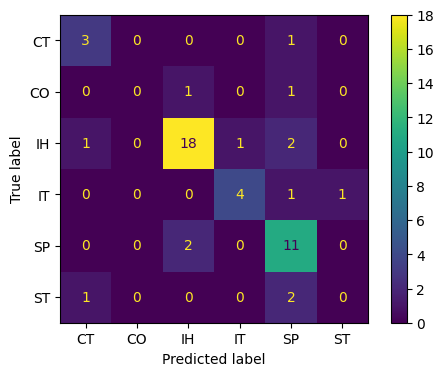

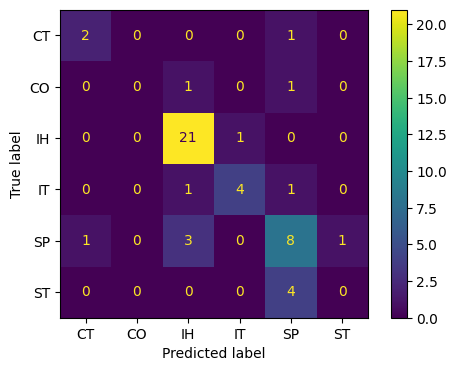

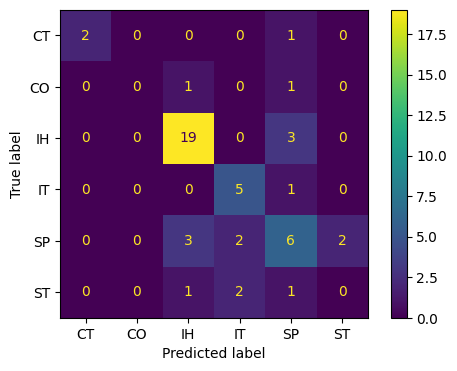

In [8]:


smote = ADASYN(random_state=RANDOM_SEED)

rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
# rf = svm.SVC(kernel="rbf", C=1)
# rf = LinearSVC(C=1, n_jobs=-1)

# X = X.replace(-1, 0)
# rf = naive_bayes.MultinomialNB()

scaler = Normalizer()


skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=RANDOM_SEED)

precision_scores = np.zeros(K)
recall_scores = np.zeros(K)
f1_scores = np.zeros(K)
mcc_scores = np.zeros(K)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index] 
    y_test = y.iloc[test_index]
    
    # X_train, y_train = smote.fit_resample(X_train, y_train)
#     scaler.fit(X_train)
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)
    

    rf.fit(X_train, y_train)
    
    # Get feature importances
    # importances = rf.feature_importances_

    # Print feature importances
#     for feature, importance in zip(rf.feature_names_in_, importances):
#         print(f'{feature}: {importance}')
    
    y_pred = rf.predict(X_test)
    # print("Unique predictions: ", np.unique(y_pred))
    # print("Unique training classes in split: ", y_train.value_counts())
    # print("Unique test classes in split: ", y_test.value_counts())
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=FEATURE_ABBREV, labels=FEATURE_NAMES)
    
    
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    precision_scores[i] = precision
    recall_scores[i] = recall
    f1_scores[i] = f1
    mcc_scores[i] = mcc

    # print("%0.2f\t%0.2f\t%0.2f\t%0.2f"% (precision, recall, f1, mcc))

print("===AVG, STD===")
print("Precision: ", np.mean(precision_scores), np.std(precision_scores))
print("Recall: ", np.mean(recall_scores), np.std(recall_scores))
print("F1: ", np.mean(f1_scores), np.std(f1_scores))
print("MCC: ", np.mean(mcc_scores), np.std(mcc_scores))

# Multi-class classification

#### Training setup and helper functions.

In [348]:
cv = RepeatedStratifiedKFold(n_splits=K, n_repeats=10, random_state=RANDOM_SEED)
metrics = {'precision': make_scorer(precision_score, average='weighted', zero_division=1),
           'recall': make_scorer(recall_score, average='weighted', zero_division=1),
           'f1': make_scorer(f1_score, average='weighted', zero_division=1),
           'mcc': make_scorer(mcc_score)}

def convert_name(class_name):
    class_name = class_name.removeprefix("\src\\")
    class_name = class_name.removesuffix(".java")
    class_name = class_name.replace(".", "$")
    class_name = class_name.replace("\\", ".")

    return class_name

def mcc_score(y_true, y_pred):
    return matthews_corrcoef(y_true, y_pred)

mcc_scorer = make_scorer(mcc_score)

#### Load data, define pipeline to preprocess data and train models.

In [349]:
def load_data(data_path: str, drop_cols: list, filter_name: str = None):
    raw_data = pd.read_csv(data_path)
    
    if not filter_name is None:
        raw_data = raw_data[raw_data["fullpathname"].str.contains(filter_name, case=False)]
    
    X = raw_data.drop(columns=drop_cols)
    y = raw_data["label"]
    
    return X, y

def get_pipeline(scaler: str, resampler: str, model: str, cat_features: list = None):
    scaler = scaler.lower()
    resampler = resampler.lower()
    model = model.lower()
    
    pipe = Pipeline(steps=[])
    
    onehotencoder = ColumnTransformer(transformers=[("cat", OneHotEncoder(), cat_features)], remainder="passthrough")
    
    if not cat_features is None:
        pipe.steps.append(["onehotencoder", onehotencoder])
    
    if model == "mnb": # MNB doesn't work with negative values, so replace the -1's with 0's.
        pipe.steps.append(["imputer", SimpleImputer(missing_values=-1, fill_value=0, strategy="constant")])
    
    if scaler == "standard":
        pipe.steps.append(["scaler", StandardScaler()])
    elif scaler == "normalizer":
        pipe.steps.append(["scaler", Normalizer()])
    
    if resampler == "smote":
        pipe.steps.append(["resampler", SMOTE()])
    elif resampler == "adasyn":
        pipe.steps.append(["resampler", ADASYN()])
        
    if model == "rf":
        pipe.steps.append(["clf", RandomForestClassifier(n_estimators=1000, max_depth=5000, max_features=4000, n_jobs=-1)])
    elif model == "svm":
        pipe.steps.append(["clf", SVC(kernel='linear', C=1)])
    elif model == "mnb":
        pipe.steps.append(["clf", MultinomialNB(alpha=100)])
    
    return pipe

def train_pipe(pipeline, X, y, cv, metrics):
    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=metrics, return_train_score=True, n_jobs=-1)
    
    precision_scores_train = cv_results["train_precision"]
    recall_scores_train = cv_results["train_recall"]
    f1_scores_train = cv_results["train_f1"]
    mcc_scores_train = cv_results["train_mcc"]
    
    precision_scores = cv_results["test_precision"]
    recall_scores = cv_results["test_recall"]
    f1_scores = cv_results["test_f1"]
    mcc_scores = cv_results["test_mcc"]
    
    print("====== CONFIGURATION ======")
    print(pipeline)
    
    print("=== TRAIN SCORES (average, std) ===")
    print(f"Precision: {precision_scores_train.mean().round(ROUND), precision_scores_train.std().round(ROUND)}")
    print(f"Recall: {recall_scores_train.mean().round(ROUND), recall_scores_train.std().round(ROUND)}")
    print(f"F1: {f1_scores_train.mean().round(ROUND), f1_scores_train.std().round(ROUND)}")
    print(f"MCC: {mcc_scores_train.mean().round(ROUND), mcc_scores_train.std().round(ROUND)}")
    
    print("=== TEST SCORES (average, std) ===")
    print(f"Precision: {precision_scores.mean().round(ROUND), precision_scores.std().round(ROUND)}")
    print(f"Recall: {recall_scores.mean().round(ROUND), recall_scores.std().round(ROUND)}")
    print(f"F1: {f1_scores.mean().round(ROUND), f1_scores.std().round(ROUND)}")
    print(f"MCC: {mcc_scores.mean().round(ROUND), mcc_scores.std().round(ROUND)}")
    print("\n")

# Training based on our own dataset.
data_path = f"/Users/mboopi/Documents/GitHub/JavaClassClassification/data/dataset/{PROJECT_NAME}/features_{PROJECT_NAME}_FINAL.csv"
drop_cols = ["className", "label",#, 
             "avgExecTime"]
X, y = load_data(data_path, drop_cols)

pipelines = [get_pipeline("standard", "", "svm"), 
             get_pipeline("normalizer", "adasyn", "mnb"), 
             get_pipeline("", "", "rf")]

for pipe in pipelines:
    train_pipe(pipe, X, y, cv, metrics)

====== CONFIGURATION ======
Pipeline(steps=[['scaler', StandardScaler()],
                ['clf', SVC(C=1, kernel='linear')]])
=== TRAIN SCORES (average, std) ===
Precision: (0.64, 0.03)
Recall: (0.62, 0.01)
F1: (0.59, 0.01)
MCC: (0.45, 0.02)
=== TEST SCORES (average, std) ===
Precision: (0.61, 0.07)
Recall: (0.57, 0.06)
F1: (0.53, 0.06)
MCC: (0.38, 0.1)


====== CONFIGURATION ======
Pipeline(steps=[['imputer',
                 SimpleImputer(fill_value=0, missing_values=-1,
                               strategy='constant')],
                ['scaler', Normalizer()], ['resampler', ADASYN()],
                ['clf', MultinomialNB(alpha=100)]])
=== TRAIN SCORES (average, std) ===
Precision: (0.71, 0.06)
Recall: (0.28, 0.05)
F1: (0.25, 0.06)
MCC: (0.19, 0.05)
=== TEST SCORES (average, std) ===
Precision: (0.72, 0.08)
Recall: (0.26, 0.06)
F1: (0.24, 0.07)
MCC: (0.18, 0.06)


====== CONFIGURATION ======
Pipeline(steps=[['clf',
                 RandomForestClassifier(max_depth=5000, max_fea

#### Replication: training models based on the dataset of the paper (only classes of SweetHome3D).

In [350]:
data_path_paper = "/Users/mboopi/Documents/KY/CSE_Y3/Q2:3/Thesis/JSS2019_SCAM_ReplicationPackage/Classification Experiment/dataset/multi-class classification/three-cases-20190301.csv"
drop_cols_paper = ["index", "fullpathname", "classname", "label"]
cat_features = ["classPublicity"]

# Training on all classes of the paper.
X_paper, y_paper = load_data(data_path_paper, drop_cols_paper, filter_name=PROJECT_NAME)

pipelines = [#get_pipeline("standard", "", "svm", cat_features), 
             # get_pipeline("normalizer", "adasyn", "mnb", cat_features), 
             get_pipeline("", "", "rf", cat_features)]

print("====== TRAINING ON ALL CLASSES OF THE PAPER ======")
for pipe in pipelines:
    train_pipe(pipe, X_paper, y_paper, cv, metrics)


# Training on only the classes that are also present in our own dataset.
raw_data = pd.read_csv(data_path)
raw_data_paper = pd.read_csv(data_path_paper)
raw_data_paper = raw_data_paper[raw_data_paper["fullpathname"].str.contains(PROJECT_NAME, case=False)]
raw_data_paper["className"] = raw_data_paper["fullpathname"].apply(lambda x: convert_name(x))

merged_data = pd.merge(raw_data["className"], raw_data_paper, on="className", how="inner")
y_merged = merged_data["label"]
X_merged = merged_data.drop(columns=["className", "index", "fullpathname", "label", "classname"])

print("====== TRAINING ON ONLY THE CLASSES THAT ARE PRESENT IN OUR OWN DATASET ======")
pipelines = [#get_pipeline("standard", "", "svm", cat_features), 
             # get_pipeline("normalizer", "adasyn", "mnb", cat_features), 
             get_pipeline("", "", "rf", cat_features)]

for pipe in pipelines:
    train_pipe(pipe, X_merged, y_merged, cv, metrics)

# Training on static and dynamic features combined.
combined_data = pd.merge(raw_data, raw_data_paper, on="className", how="inner")
y_combined = combined_data["label_x"]
X_combined = combined_data.drop(columns=["className", "index", "fullpathname", "label_y", "label_x", "classname"])

print("====== TRAINING ON COMBINATION OF STATIC AND DYNAMIC FEATURES ======")
pipelines = [#get_pipeline("standard", "", "svm", cat_features), 
             # get_pipeline("normalizer", "adasyn", "mnb", cat_features), 
             get_pipeline("", "", "rf", cat_features)]

for pipe in pipelines:
    train_pipe(pipe, X_combined, y_combined, cv, metrics)


====== TRAINING ON ALL CLASSES OF THE PAPER ======
====== CONFIGURATION ======
Pipeline(steps=[['onehotencoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['classPublicity'])])],
                ['clf',
                 RandomForestClassifier(max_depth=5000, max_features=4000,
                                        n_estimators=1000, n_jobs=-1)]])
=== TRAIN SCORES (average, std) ===
Precision: (0.99, 0.0)
Recall: (0.99, 0.0)
F1: (0.99, 0.0)
MCC: (0.99, 0.0)
=== TEST SCORES (average, std) ===
Precision: (0.76, 0.05)
Recall: (0.75, 0.05)
F1: (0.73, 0.05)
MCC: (0.65, 0.07)


====== TRAINING ON ONLY THE CLASSES THAT ARE PRESENT IN OUR OWN DATASET ======
====== CONFIGURATION ======
Pipeline(steps=[['onehotencoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
   